In [1]:
from __future__ import print_function
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import time

import torchvision
from torch.utils.data import Dataset, DataLoader
import math

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torchvision import datasets
import torchvision.transforms as transforms

import seaborn as sns

from datetime import datetime

plt.rc('text', usetex=True)
plt.rc('font', family='Time New Roman')

/home/jun/anaconda3/envs/jun/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# JET

In [2]:
jet_S6S6 = torch.from_numpy( np.loadtxt('.../Events/Jet_S6S6.csv').astype(np.float32) ).reshape(-1,3,50,50)
jet_S8S8 = torch.from_numpy( np.loadtxt('.../Events/Jet_S8S8.csv').astype(np.float32) ).reshape(-1,3,50,50)
jet_S8 = torch.from_numpy( np.loadtxt('.../Events/Jet_S8.csv').astype(np.float32) ).reshape(-1,3,50,50)
jet_S6 = torch.from_numpy( np.loadtxt('.../Events/Jet_S6.csv').astype(np.float32) ).reshape(-1,3,50,50)

jet_ttVV = torch.from_numpy( np.loadtxt('.../Events/Jet_BKG_ttVV.csv').astype(np.float32) ).reshape(-1,3,50,50)
jet_ttV = torch.from_numpy( np.loadtxt('.../Events/Jet_BKG_ttV.csv').astype(np.float32) ).reshape(-1,3,50,50)
jet_tth = torch.from_numpy( np.loadtxt('.../Events/Jet_BKG_tth.csv').astype(np.float32) ).reshape(-1,3,50,50)
jet_tttt = torch.from_numpy( np.loadtxt('.../Events/Jet_BKG_tttt.csv').astype(np.float32) ).reshape(-1,3,50,50)
jet_VVV = torch.from_numpy( np.loadtxt('.../Events/Jet_BKG_VVV.csv').astype(np.float32) ).reshape(-1,3,50,50)

In [3]:
# mass : [1.2-2.5]TeV
# each # : 70000
# 3 : 1.5

i = 3
jet_S8S8_1500 = jet_S8S8[70000*i:70000*(i+1)]
jet_S6S6_1500 = jet_S6S6[70000*i:70000*(i+1)]
jet_S8_1500 = jet_S8[70000*i:70000*(i+1)]
jet_S6_1500 = jet_S6[70000*i:70000*(i+1)]

jet_ttVV_ = jet_ttVV
jet_ttV_ = jet_ttV
jet_tth_ = jet_tth
jet_tttt_ = jet_tttt

In [4]:
jet_S6S6_c_1500 = jet_S6S6_1500[:,0].mean(dim=0)
jet_S6S6_n_1500 = jet_S6S6_1500[:,1].mean(dim=0)
jet_S6S6_l_1500 = jet_S6S6_1500[:,2].mean(dim=0)

jet_S8S8_c_1500 = jet_S8S8_1500[:,0].mean(dim=0)
jet_S8S8_n_1500 = jet_S8S8_1500[:,1].mean(dim=0)
jet_S8S8_l_1500 = jet_S8S8_1500[:,2].mean(dim=0)

jet_S8_c_1500 = jet_S8_1500[:,0].mean(dim=0)
jet_S8_n_1500 = jet_S8_1500[:,1].mean(dim=0)
jet_S8_l_1500 = jet_S8_1500[:,2].mean(dim=0)

jet_S6_c_1500 = jet_S6_1500[:,0].mean(dim=0)
jet_S6_n_1500 = jet_S6_1500[:,1].mean(dim=0)
jet_S6_l_1500 = jet_S6_1500[:,2].mean(dim=0)

jet_ttVV_c = jet_ttVV_[:,0].mean(dim=0)
jet_ttVV_n = jet_ttVV_[:,1].mean(dim=0)
jet_ttVV_l = jet_ttVV_[:,2].mean(dim=0)

jet_ttV_c = jet_ttV_[:,0].mean(dim=0)
jet_ttV_n = jet_ttV_[:,1].mean(dim=0)
jet_ttV_l = jet_ttV_[:,2].mean(dim=0)

jet_tth_c = jet_tth_[:,0].mean(dim=0)
jet_tth_n = jet_tth_[:,1].mean(dim=0)
jet_tth_l = jet_tth_[:,2].mean(dim=0)

jet_tttt_c = jet_tttt_[:,0].mean(dim=0)
jet_tttt_n = jet_tttt_[:,1].mean(dim=0)
jet_tttt_l = jet_tttt_[:,2].mean(dim=0)

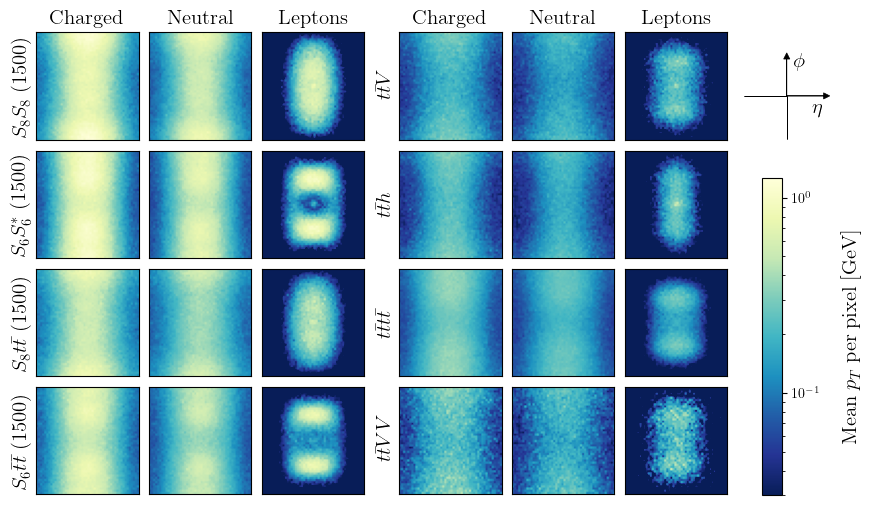

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

backgrounds = [r'$S_8S_8\;(1500)$', r'$S_6S_6^*\;(1500)$', r'$S_8t\bar{t}\;(1500)$', r'$S_6\bar{t}\bar{t}\;(1500)$']
background_images = {
    r'$S_8S_8\;(1500)$': [jet_S8S8_c_1500.numpy(), jet_S8S8_n_1500.numpy(), jet_S8S8_l_1500.numpy()],
    r'$S_6S_6^*\;(1500)$': [jet_S6S6_c_1500.numpy(), jet_S6S6_n_1500.numpy(), jet_S6S6_l_1500.numpy()],
    r'$S_8t\bar{t}\;(1500)$':   [jet_S8_c_1500.numpy(),   jet_S8_n_1500.numpy(),   jet_S8_l_1500.numpy()],
    r'$S_6\bar{t}\bar{t}\;(1500)$': [jet_S6_c_1500.numpy(), jet_S6_n_1500.numpy(), jet_S6_l_1500.numpy()],

}

signals = [r'$t\bar{t}V$', r'$t\bar{t}h$', r'$t\bar{t}t\bar{t}$', r'$t\bar{t}VV$']
signal_images = {
    r'$t\bar{t}V$':  [jet_ttV_c.numpy(),  jet_ttV_n.numpy(),  jet_ttV_l.numpy()],
    r'$t\bar{t}h$':  [jet_tth_c.numpy(),  jet_tth_n.numpy(),  jet_tth_l.numpy()],
    r'$t\bar{t}t\bar{t}$': [jet_tttt_c.numpy(), jet_tttt_n.numpy(), jet_tttt_l.numpy()],
    r'$t\bar{t}VV$': [jet_ttVV_c.numpy(), jet_ttVV_n.numpy(), jet_ttVV_l.numpy()]
}

col_labels = ['Charged', 'Neutral', 'Leptons']

all_images = [img for proc in background_images.values() for img in proc] + \
             [img for proc in signal_images.values() for img in proc]

epsilon = 0.03
global_min_value = min([img.min() for img in all_images])
global_max_value = max([img.max() for img in all_images])
global_min_value_adj = global_min_value if global_min_value > epsilon else epsilon

norm = colors.LogNorm(vmin=global_min_value_adj, vmax=global_max_value)

shift = 1e-3 

fig = plt.figure(figsize=(10, 6))
outer = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.15], wspace=0.15)

gs_left = gridspec.GridSpecFromSubplotSpec(4, 3, subplot_spec=outer[0],
                                            hspace=0.1, wspace=0.1)
for i, proc in enumerate(backgrounds):
    for j in range(3):
        ax = fig.add_subplot(gs_left[i, j])
        if j == 2:
            img = background_images[proc][j] + shift
        else:
            img = background_images[proc][j]
        ax.imshow(img, origin='upper', cmap='YlGnBu_r', aspect='auto', norm=norm)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(col_labels[j], fontsize=15)
        if j == 0:
            ax.set_ylabel(proc, fontsize=15)

gs_mid = gridspec.GridSpecFromSubplotSpec(4, 3, subplot_spec=outer[1],
                                           hspace=0.1, wspace=0.1)
for i, proc in enumerate(signals):
    for j in range(3):
        ax = fig.add_subplot(gs_mid[i, j])
        if j == 2:
            img = signal_images[proc][j] + shift
        else:
            img = signal_images[proc][j]
        ax.imshow(img, origin='upper', cmap='YlGnBu_r', aspect='auto', norm=norm)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(col_labels[j], fontsize=15)
        if j == 0:
            ax.set_ylabel(proc, fontsize=15)

for j in range(3):
    ax = fig.add_subplot(gs_mid[3, j])
    ax.axis('off')

gs_right = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[2],
                                             height_ratios=[0.4, 0.6], hspace=0.1)

ax_coord = fig.add_subplot(gs_right[0])
ax_coord.set_xlim(-2, 2)
ax_coord.set_ylim(-2, 2)
ax_coord.set_aspect('equal')
ax_coord.axis('off')
ax_coord.arrow(0, 2, 3.5, 0, head_width=0.5, head_length=0.5, fc='k', ec='k',
               linewidth=0.5, length_includes_head=True, clip_on=False)
ax_coord.arrow(0, 2, -3.5, 0, head_width=0.0, head_length=0.5, fc='k', ec='k',
               linewidth=0.5, length_includes_head=True, clip_on=False)
ax_coord.arrow(0, 2, 0, 3.5, head_width=0.5, head_length=0.5, fc='k', ec='k',
               linewidth=0.5, length_includes_head=True, clip_on=False)
ax_coord.arrow(0, 2, 0, -3.5, head_width=0.0, head_length=0.5, fc='k', ec='k',
               linewidth=0.5, length_includes_head=True, clip_on=False)
ax_coord.text(2.05, 1, r'$\eta$', fontsize=15, ha='left', va='center')
ax_coord.text(1, 4.05, r'$\phi$', fontsize=15, ha='center', va='bottom')

sm = cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])
ax_cbar = fig.add_subplot(gs_right[1])
cbar = fig.colorbar(sm, cax=ax_cbar)
ax_cbar.set_ylabel(r'${\rm Mean}\; p_T\; \rm per\; pixel\; [GeV]$', rotation=90, labelpad=15, fontsize=15)

pos = ax_cbar.get_position()
new_width = pos.width * 0.4
new_height = pos.height * 1.2
new_x0 = pos.x0 + (pos.width - new_width) / 1000
new_y0 = pos.y0 - (new_height - pos.height) / 100
ax_cbar.set_position([new_x0, new_y0, new_width, new_height])

plt.savefig("./jet.pdf", bbox_inches='tight', pad_inches=0.05, transparent=True)
plt.show()

# ROC

In [11]:
from scipy.interpolate import interp1d
eps_B_, eps_B_std = [], []
svals = np.linspace(0.577,0.99,1000)
bvals = []
    
for run in range(1, 21):
    Results = np.loadtxt(f"./CNN_S6S6_vs_BKG/DNN_score{run}_2300.txt")

    n_bins = 100000
    lumi = 3000
    Xreco_Sig = 0.0005793761738685725
    Xreco_ttVV = 0.033163
    Xreco_ttV = 0.25351
    Xreco_tth = 0.19797
    Xreco_tttt = 0.19324
    Xreco_VVV = 0.00077492

    a = 12491
    b = 610
    c = 4666
    d = 3644
    e = 3557
    f = 14

    Results_Sig = Results[:a]
    Results_ttVV = Results[a:a+b]
    Results_ttV = Results[a+b:a+c]
    Results_tth = Results[a+b+c:a+b+c+d]
    Results_tttt = Results[a+b+c+d:a+b+c+d+e]
    Results_VVV = Results[a+b+c+d+e:a+b+c+d+e+f]

    histo, _ = np.histogram(Results_Sig, n_bins, range=(0,1), density=True)
    xs = Xreco_Sig
    events_per_bin = histo/n_bins*xs*lumi
    signals_per_bin = events_per_bin   

    histo, _ = np.histogram(Results_ttVV, n_bins, range=(0,1), density=True)
    xs = Xreco_ttVV
    events_per_bin = histo/n_bins*xs*lumi
    ttVV_per_bin = events_per_bin

    histo, _ = np.histogram(Results_ttV, n_bins, range=(0,1), density=True)
    xs = Xreco_ttV
    events_per_bin = histo/n_bins*xs*lumi
    ttV_per_bin = events_per_bin

    histo, _ = np.histogram(Results_tth, n_bins, range=(0,1), density=True)
    xs = Xreco_tth
    events_per_bin = histo/n_bins*xs*lumi
    tth_per_bin = events_per_bin

    histo, _ = np.histogram(Results_tttt, n_bins, range=(0,1), density=True)
    xs = Xreco_tttt
    events_per_bin = histo/n_bins*xs*lumi
    tttt_per_bin = events_per_bin

    histo, _ = np.histogram(Results_VVV, n_bins, range=(0,1), density=True)
    xs = Xreco_VVV
    events_per_bin = histo/n_bins*xs*lumi
    VVV_per_bin = events_per_bin

    cumulative_total_signals = np.zeros(n_bins)
    cumulative_total_signals = np.cumsum(signals_per_bin[::-1])

    cumulative_total_backgrounds = np.zeros(n_bins)
    cumulative_total_backgrounds += np.cumsum(ttVV_per_bin[::-1])
    cumulative_total_backgrounds += np.cumsum(ttV_per_bin[::-1])
    cumulative_total_backgrounds += np.cumsum(tth_per_bin[::-1])
    cumulative_total_backgrounds += np.cumsum(tttt_per_bin[::-1])
    cumulative_total_backgrounds += np.cumsum(VVV_per_bin[::-1])

    total_S, total_B = cumulative_total_signals[-1], cumulative_total_backgrounds[-1]
    eps_S = cumulative_total_signals/total_S
    eps_B = cumulative_total_backgrounds/total_B

    func = interp1d(eps_S.flatten(), eps_B.flatten(), fill_value='extrapolate')

    bvals.append(func(svals))
    
bvals = np.array(bvals)
mean = np.mean(bvals, axis=0)
eps_B_.append(1/mean)
eps_B = eps_B_[0]
std = np.std(bvals, axis=0)
stdinv = std/(mean*mean)
is_only_pos = stdinv*mean < 0.5
# is_only_pos = 1/mean < 1200
svals_S6S6_CNN = svals[is_only_pos]
mean_S6S6_CNN = mean[is_only_pos]
stdinv_S6S6_CNN = stdinv[is_only_pos]

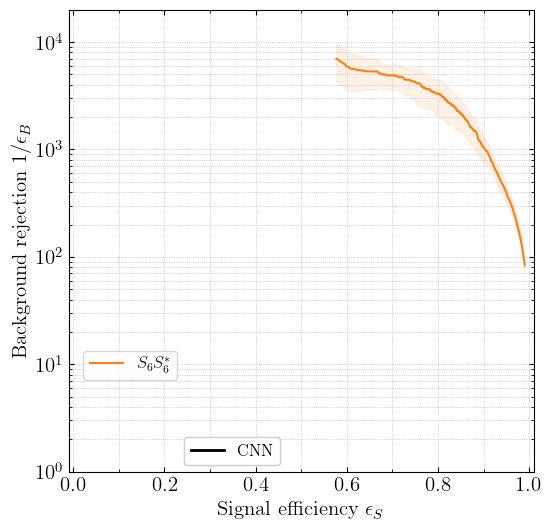

In [12]:
import matplotlib as mpl
#plt.rc('text', usetex=True)
#plt.rc('font', family='Time New Roman')

plt.rcParams.update({"font.size": 15})
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
    
ax.plot(svals_S6S6_CNN, 1/mean_S6S6_CNN, color="C1", linestyle='-')
ax.fill_between(svals_S6S6_CNN, 1/mean_S6S6_CNN+stdinv_S6S6_CNN, 1/mean_S6S6_CNN-stdinv_S6S6_CNN, alpha=0.1, color="C1", linestyle='-')

ax.tick_params(which='both', direction="in", right=True, top=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.grid(which='both', linewidth=0.5, linestyle=':')
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(1, 2e4)
ax.set_yscale('log')
ax.set_xlabel("Signal efficiency $\epsilon_S$")
ax.set_ylabel("Background rejection $1/\epsilon_B$")

#ax.plot([0, 1], [0, 0], c="C0", ls="-", label=r"$S_8S_8$")
ax.plot([0, 1], [0, 0], c="C1", ls="-", label=r"$S_6S_6^*$")
#ax.plot([0, 1], [0, 0], c="C2", ls="-", label=r"$S_8t\bar{t}$")
#ax.plot([0, 1], [0, 0], c="C3", ls="-", label=r"$S_6\bar{t}\bar{t}$")

legend1 = ax.legend(fontsize=12, bbox_to_anchor=(0.25, 0.28))
#line3 = ax.axhline(0, color='black', linestyle="-", label="CNN")
#line4 = ax.axhline(0, color='black', linestyle="--", label="MLP")
#legend2 = ax.legend(handles=[line3, line4], fontsize=12, bbox_to_anchor=(0.47, 0.22))

ax.add_artist(legend1)

from matplotlib.lines import Line2D
style_handles = [
    Line2D([0],[0], color="k", lw=2, ls="-"),
    Line2D([0],[0], color="k", lw=2, ls="--"),
]
style_labels = ["CNN"]

legend2 = ax.legend(style_handles, style_labels,
                    loc="lower left", bbox_to_anchor=(0.23, -0.0045),
                    fontsize=12, frameon=True)

ax.add_artist(legend2)

plt.savefig("./roc.pdf", bbox_inches = 'tight',pad_inches = 0.01, transparent=True)
plt.show()

# Significance

In [13]:
def Like(s, b, u, n):
    return math.e**((n*s+b)*math.log(u*s+b)-math.lgamma(n*s+b+1)-(u*s+b))

def IndiLikeRatioDis(NS1, NB1):
    return math.sqrt(-2*math.log((Like(NS1, NB1, 0.0, 1.0))/(Like(NS1, NB1, 1.0, 1.0))))

In [16]:
XSig_box = []

Xbkg_box = []

Xbkg_ttVV_box = []

Xbkg_ttV_box = []

Xbkg_tth_box = []

Xbkg_tttt_box = []

Xbkg_VVV_box = []

nn = 10000

Ival = 0.0

Xreco_Sig = 0.0005793761738685725

Xreco_ttVV = 0.033163

Xreco_ttV = 0.25351

Xreco_tth = 0.19797

Xreco_tttt = 0.19324

Xreco_VVV = 0.00077492

for j in range(0, nn):

    roc_sig = 0
    roc_bkg_ttVV = 0
    roc_bkg_ttV = 0
    roc_bkg_tth = 0
    roc_bkg_tttt = 0
    roc_bkg_VVV = 0

    for i in range(0, len(Results_Sig)):
        if Results_Sig[i] > float( Ival + float((1.0-Ival)*j)/float(nn) ) :
            roc_sig = roc_sig + 1

    for i in range(0, len(Results_ttVV )):
        if Results_ttVV[i] > float( Ival + float((1.0-Ival)*j)/float(nn) ) :
            roc_bkg_ttVV = roc_bkg_ttVV + 1

    for i in range(0, len(Results_ttV) ):
        if Results_ttV[i] > float( Ival + float((1.0-Ival)*j)/float(nn) ) :
            roc_bkg_ttV = roc_bkg_ttV + 1

    for i in range(0, len(Results_tth )):
        if Results_tth[i] > float( Ival + float((1.0-Ival)*j)/float(nn) ) :
            roc_bkg_tth = roc_bkg_tth + 1

    for i in range(0, len(Results_tttt) ):
        if Results_tttt[i] > float( Ival + float((1.0-Ival)*j)/float(nn) ) :
            roc_bkg_tttt = roc_bkg_tttt + 1

    for i in range(0, len(Results_VVV) ):
        if Results_VVV[i] > float( Ival + float((1.0-Ival)*j)/float(nn) ) :
            roc_bkg_VVV = roc_bkg_VVV + 1

    XSig_box.append( float( float(Xreco_Sig)*float( roc_sig ) / float( len(Results_Sig) ) )   )

    Xbkg_box.append( float( float(Xreco_ttVV)*float( roc_bkg_ttVV ) / float( len(Results_ttVV) ) ) + float( float(Xreco_ttV)*float( roc_bkg_ttV ) / float( len(Results_ttV) ) ) + float( float(Xreco_tth)*float( roc_bkg_tth ) / float( len(Results_tth) ) ) + float( float(Xreco_tttt)*float( roc_bkg_tttt ) / float( len(Results_tttt) ) ) + float( float(Xreco_VVV)*float( roc_bkg_VVV ) / float( len(Results_VVV) ) ) )

    Xbkg_ttVV_box.append( float( float(Xreco_ttVV)*float( roc_bkg_ttVV ) / float( len(Results_ttVV) ) )  )

    Xbkg_ttV_box.append( float( float(Xreco_ttV)*float( roc_bkg_ttV ) / float( len(Results_ttV) ) )   )

    Xbkg_tth_box.append( float( float(Xreco_tth)*float( roc_bkg_tth ) / float( len(Results_tth) ) )  )

    Xbkg_tttt_box.append( float( float(Xreco_tttt)*float( roc_bkg_tttt ) / float( len(Results_tttt) ) )   )

    Xbkg_VVV_box.append( float( float(Xreco_VVV)*float( roc_bkg_VVV ) / float( len(Results_VVV) ) )   )

SobSqrtB_ = []
Nsig_ = []

for j in range(0, len(XSig_box) ):

    if float( Xbkg_box[j] ) == 0 :
        break

    Nsig = round( float( 3000*XSig_box[j] ), 3)
    Nsig_.append(Nsig)

    Nbkg = round( float( 3000*Xbkg_box[j] ), 3)

    Nbkg_ttVV = round( float( 3000*Xbkg_ttVV_box[j] ), 3)

    Nbkg_ttV = round( float( 3000*Xbkg_ttV_box[j] ), 3)

    Nbkg_tth = round( float( 3000*Xbkg_tth_box[j] ), 3)

    Nbkg_tttt = round( float( 3000*Xbkg_tttt_box[j] ), 3)

    Nbkg_VVV = round( float( 3000*Xbkg_VVV_box[j] ), 3)

    try:
        SobSqrtB = (round(float(IndiLikeRatioDis(float(Nsig), float(Nbkg))), 3))
        SobSqrtB_.append(SobSqrtB)
    except ValueError:
        continue